To-Dos:
- [ ] Create separate preprocessing piplines both including and excluding features that were used to calculate new features
- [ ] Apply reduced preprocessing to Ridge and KNN; full preprocessing to tree-based models

# Project Description

# Establishing professor's baseline

In [4]:
## Import all needed libraries
import numpy as np
import pandas as pd
import json
import logging
import zipfile
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import r2_score, mean_absolute_error

## Initiate common random state
r_state = 123


In [5]:
# Set up logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

# Log the start of the process
logging.info("Reading train and test files")

# Read the full dataset
data = pd.read_json("train.json", orient='records')
test = pd.read_json("test.json", orient='records')

# Fill missing 'rooms' where room_type is private/shared/hotel with 1
room_fill_conditions = data['room_type'].isin(['private_room', 'shared_room', 'hotel_room'])

# Only apply the fill where 'rooms' is NaN and room type is a single room type
data.loc[room_fill_conditions & data['rooms'].isna(), 'rooms'] = 1

# Split the full data into train and validation BEFORE any transformation
raw_train, raw_valid = train_test_split(data, test_size=1/3, random_state=r_state)

drop_cols = ['host', 'name', 'facilities', #'guests', 
             'revenue']  # add others like 'beds' or 'cancellation' if needed
label = 'revenue'

X_train = raw_train.drop(columns=drop_cols)
y_train = raw_train[label]  # Do not transform yet

X_valid = raw_valid.drop(columns=drop_cols)
y_valid = raw_valid[label]


2025-05-11 22:09:24,299 - INFO - Reading train and test files


In [6]:
print(X_train.shape)
print(X_valid.shape)

(10178, 12)
(5090, 12)


# Environment set-up & data import

In [8]:
# --- Core ---
import pandas as pd
import numpy as np
import logging

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn: Preprocessing ---
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# --- Scikit-learn: Models ---
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor
)

# --- Scikit-learn: Metrics ---
from sklearn.metrics import mean_absolute_error

# --- Other ML Libraries ---
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# --- Optional: Feature Engineering Tools ---
# from sklearn.cluster import KMeans
# from geopy.distance import geodesic

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')


2025-05-11 22:09:24,612 - DEBUG - matplotlib data path: C:\Users\chels\anaconda3\Lib\site-packages\matplotlib\mpl-data
2025-05-11 22:09:24,617 - DEBUG - CONFIGDIR=C:\Users\chels\.matplotlib
2025-05-11 22:09:24,619 - DEBUG - interactive is False
2025-05-11 22:09:24,619 - DEBUG - platform is win32
2025-05-11 22:09:24,729 - DEBUG - CACHEDIR=C:\Users\chels\.matplotlib
2025-05-11 22:09:24,734 - DEBUG - Using fontManager instance from C:\Users\chels\.matplotlib\fontlist-v330.json
2025-05-11 22:09:25,079 - DEBUG - deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-05-11 22:09:25,081 - DEBUG - deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-05-11 22:09:25,082 - DEBUG - deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2025-05-11 22:09:25,084 - DEBUG - deprecate positional args: graphviz.backend.viewing.vie

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load train and test data
logging.info("Loading train and test data...")
data = pd.read_json("train.json", orient="records")
test = pd.read_json("test.json", orient="records")

# Drop unused columns
drop_cols = ['host', 'name']
data.drop(columns=drop_cols, inplace=True)

# Domain-informed imputation: fill missing 'rooms' where room_type implies 1 room
room_fill_mask = data['room_type'].isin(['private_room', 'shared_room', 'hotel_room']) & data['rooms'].isna()
data.loc[room_fill_mask, 'rooms'] = 1 



# Split BEFORE any transformations
r_state = 123
raw_train, raw_valid = train_test_split(data, test_size=1/3, random_state=r_state)




2025-05-11 22:09:26,028 - INFO - Loading train and test data...


# Explore data

From table below, can see that:
- min_nights and num_reviews are heavily skewed (substantial difference between mean and median)
- The top value of min_nights is nonsensical (should be winsorized to avoid losing data)

In [12]:
raw_train.describe()

,lat,lon,rooms,bathrooms,beds,min_nights,num_reviews,rating,guests,revenue
count,10178.000000,10178.000000,9486.000000,10176.000000,10126.000000,10178.000000,10178.000000,10178.000000,9008.000000,10178.000000
mean,43.277133,6.908554,1.674362,1.128734,2.520837,4.936432,154.674003,4.713978,4.129107,21813.651405
std,6.429093,12.748056,1.040412,0.779804,1.894165,25.228179,166.426781,0.463090,2.232536,25560.354177
min,28.004700,-21.979200,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,136.000000
25%,38.356125,-3.592600,1.000000,1.000000,1.000000,2.000000,36.000000,4.650000,2.000000,6904.750000
50%,43.496850,6.987900,1.000000,1.000000,2.000000,2.000000,95.000000,4.790000,4.000000,14648.000000
75%,45.764500,14.423950,2.000000,1.000000,3.000000,4.000000,217.000000,4.890000,5.000000,27112.750000
max,64.421600,44.820800,17.000000,13.000000,25.000000,999.000000,1250.000000,5.000000,16.000000,473555.000000


In [13]:
percent_missing = raw_train.isna().sum()*100/len(raw_train)
percent_missing.sort_values(ascending=False)

guests          11.495382
rooms            6.798978
cancellation     1.139713
beds             0.510906
bathrooms        0.019650
lat              0.000000
lon              0.000000
room_type        0.000000
min_nights       0.000000
num_reviews      0.000000
rating           0.000000
listing_type     0.000000
facilities       0.000000
revenue          0.000000
dtype: float64

In [14]:

from scipy.stats import skew

def compare_log_skew(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in numeric_cols:
        original = df[col].dropna()

        # Skip if there are any negative values (but allow zeros for log1p)
        if (original < 0).any():
            continue

        original_skew = skew(original)
        log_skew = skew(np.log1p(original))

        results.append({
            'feature': col,
            'original_skew': round(original_skew, 3),
            'log_skew': round(log_skew, 3),
            'skew_reduction': round(abs(original_skew) - abs(log_skew), 3)
        })

    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(by='skew_reduction', ascending=False)
    return result_df


In [15]:
compare_log_skew(raw_train)

,feature,original_skew,log_skew,skew_reduction
4,min_nights,28.308,2.530,25.777
8,revenue,4.311,-0.552,3.760
2,bathrooms,2.789,-0.104,2.684
3,beds,2.880,0.755,2.125
1,rooms,2.539,1.049,1.490
7,guests,1.862,0.438,1.424
5,num_reviews,1.871,-0.531,1.340
0,lat,0.507,-0.131,0.376
6,rating,-8.466,-10.328,-1.862


In [16]:
cap_value = raw_train['min_nights'].quantile(0.99)
raw_train['min_nights'] = raw_train['min_nights'].clip(upper=cap_value)


In [17]:
raw_train.describe()

,lat,lon,rooms,bathrooms,beds,min_nights,num_reviews,rating,guests,revenue
count,10178.000000,10178.000000,9486.000000,10176.000000,10126.000000,10178.000000,10178.000000,10178.000000,9008.000000,10178.000000
mean,43.277133,6.908554,1.674362,1.128734,2.520837,3.731623,154.674003,4.713978,4.129107,21813.651405
std,6.429093,12.748056,1.040412,0.779804,1.894165,4.980577,166.426781,0.463090,2.232536,25560.354177
min,28.004700,-21.979200,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,136.000000
25%,38.356125,-3.592600,1.000000,1.000000,1.000000,2.000000,36.000000,4.650000,2.000000,6904.750000
50%,43.496850,6.987900,1.000000,1.000000,2.000000,2.000000,95.000000,4.790000,4.000000,14648.000000
75%,45.764500,14.423950,2.000000,1.000000,3.000000,4.000000,217.000000,4.890000,5.000000,27112.750000
max,64.421600,44.820800,17.000000,13.000000,25.000000,31.230000,1250.000000,5.000000,16.000000,473555.000000


2025-05-11 22:27:50,472 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001A27EB96C60>


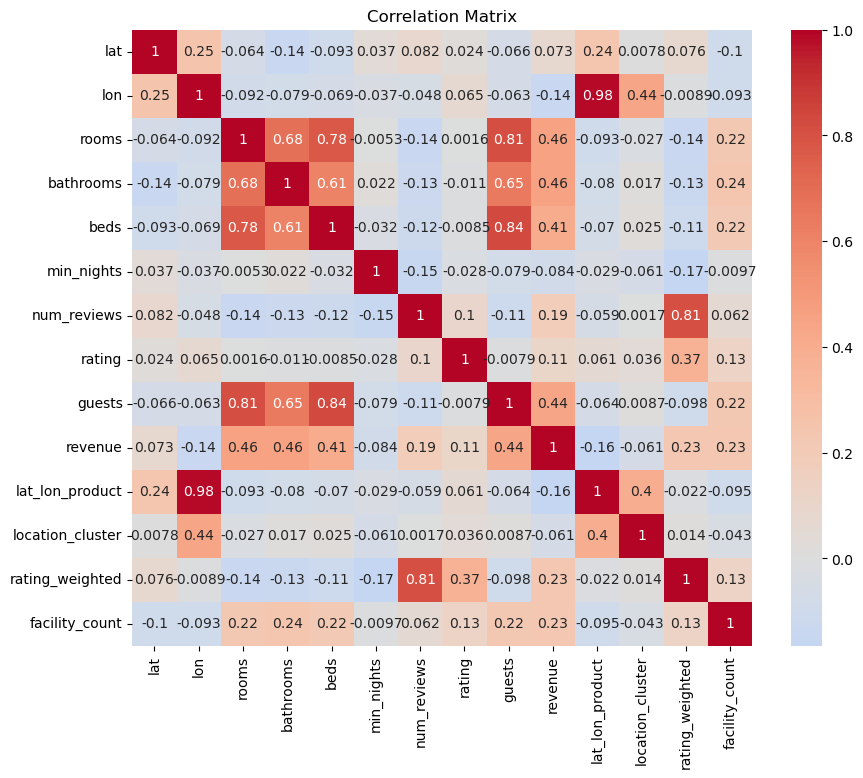

In [107]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)


plt.figure(figsize=(10, 8))
sns.heatmap(
    data=raw_train.select_dtypes(include='number').corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title("Correlation Matrix")
plt.show()


# Feature selection & engineering

Baseline model used:
- Only numerical columns (lat, lon, rooms, num_reviews)

Features to keep for the model:
- lat
- lon
- rooms
- room_type
- min_nights
- num_reviews
- rating
- cancellation
- beds
- bathrooms
- guests

Features to drop for the model:
- host
- name
- listing_type
- facilities

Transformations required:
- Log transformation: to deal with skewness of revenue, rooms, min_nights, num_reviews, rating
- Normalization: on all numerical columns so that all are on same scale
- Median imputation, due to skewness: rooms (fill with 1 wherever room_type == shared room, hotel room or private room; fill with the median for all other missing values)
- Mean imputation: lat and lon
- Dummy encoding of categorical variables: room_type

In [20]:
raw_train.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,guests,listing_type,facilities,cancellation,revenue
2148,55.9672,-3.1838,1.0,1.0,entire_home,1.0,3.00,766,4.91,2.0,Entire rental unit,TV Wifi Kitchen Free parking on premises Room-...,Strict,46779
7024,52.4999,13.4090,2.0,1.0,entire_home,4.0,31.23,151,4.40,4.0,Entire rental unit,Wifi Kitchen Free parking on premises Hot wate...,Strict,5518
14508,48.2041,16.3656,1.0,1.0,entire_home,1.0,1.00,194,4.72,4.0,Entire rental unit,TV Cable TV Wifi Crib Kitchen Hot water Elevat...,Moderate,7734
5286,47.4982,19.0567,2.0,1.0,entire_home,2.0,30.00,20,5.00,4.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Paid...,Strict,23147
10231,50.0687,19.9278,2.0,1.0,entire_home,3.0,2.00,155,4.71,6.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Hot ...,Moderate,13496


In [21]:
raw_valid.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,guests,listing_type,facilities,cancellation,revenue
738,37.0903,-8.2479,2.0,1.0,entire_home,5.0,7,18,4.83,5.0,Entire condo,TV Cable TV Wifi Air conditioning Pool Crib Ki...,Strict,13809
4759,43.6912,7.2273,3.0,2.0,entire_home,5.0,5,19,4.74,6.0,Entire rental unit,TV Washer Cable TV Dryer Smoke alarm Wifi Pool...,Strict,39868
4197,40.1852,44.5066,NaN,1.0,entire_home,1.0,4,89,4.94,2.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Room...,Strict,7180
7320,43.7735,11.2566,1.0,1.0,entire_home,2.0,2,456,4.79,2.0,Entire rental unit,TV Wifi Air conditioning Kitchen Room-darkenin...,Moderate,57623
8967,41.1494,-8.6066,3.0,1.0,entire_home,5.0,1,209,4.71,6.0,Entire rental unit,TV Cable TV Wifi Air conditioning Crib Kitchen...,Moderate,32048


## Engineer lat x lon product feature

In [23]:
raw_train['lat_lon_product'] = raw_train['lat'] * raw_train['lon']
raw_valid['lat_lon_product'] = raw_valid['lat'] * raw_valid['lon']
test['lat_lon_product'] = test['lat'] * test['lon']

## Engineer location clusters

In [25]:
from sklearn.cluster import KMeans

def add_location_clusters(df, n_clusters=5):
    coords = df[['lat', 'lon']]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['location_cluster'] = kmeans.fit_predict(coords)
    return df


In [26]:
raw_train = add_location_clusters(raw_train, n_clusters=5)
raw_valid = add_location_clusters(raw_valid, n_clusters=5)
test = add_location_clusters(test, n_clusters=5)

## Engineer rating credibility feature

In [28]:
# Feature engineering on raw_train and raw_valid
raw_train['rating_weighted'] = raw_train['rating'] * np.log1p(raw_train['num_reviews'])
raw_valid['rating_weighted'] = raw_valid['rating'] * np.log1p(raw_valid['num_reviews'])
test['rating_weighted'] = test['rating'] * np.log1p(test['num_reviews'])

## Engineer facilities count

In [30]:
import re

def count_facilities(text):
    if pd.isnull(text):
        return 0
    # Count based on capitalized facility phrases
    return len(re.findall(r'[A-Z][^A-Z]*', str(text).strip()))

In [31]:
raw_train['facility_count'] = raw_train['facilities'].apply(count_facilities)
raw_valid['facility_count'] = raw_valid['facilities'].apply(count_facilities)
test['facility_count'] = test['facilities'].apply(count_facilities)

In [32]:
raw_train['facility_count'].value_counts()

facility_count
29    294
27    294
31    292
33    292
30    288
     ... 
1       2
2       1
85      1
95      1
86      1
Name: count, Length: 88, dtype: int64

In [33]:
raw_train.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,guests,listing_type,facilities,cancellation,revenue,lat_lon_product,location_cluster,rating_weighted,facility_count
2148,55.9672,-3.1838,1.0,1.0,entire_home,1.0,3.00,766,4.91,2.0,Entire rental unit,TV Wifi Kitchen Free parking on premises Room-...,Strict,46779,-178.188371,3,32.614610,38
7024,52.4999,13.4090,2.0,1.0,entire_home,4.0,31.23,151,4.40,4.0,Entire rental unit,Wifi Kitchen Free parking on premises Hot wate...,Strict,5518,703.971159,0,22.105074,21
14508,48.2041,16.3656,1.0,1.0,entire_home,1.0,1.00,194,4.72,4.0,Entire rental unit,TV Cable TV Wifi Crib Kitchen Hot water Elevat...,Moderate,7734,788.889019,2,24.888558,26
5286,47.4982,19.0567,2.0,1.0,entire_home,2.0,30.00,20,5.00,4.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Paid...,Strict,23147,905.158948,2,15.222612,31
10231,50.0687,19.9278,2.0,1.0,entire_home,3.0,2.00,155,4.71,6.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Hot ...,Moderate,13496,997.759040,2,23.784822,28


In [34]:
raw_valid.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,guests,listing_type,facilities,cancellation,revenue,lat_lon_product,location_cluster,rating_weighted,facility_count
738,37.0903,-8.2479,2.0,1.0,entire_home,5.0,7,18,4.83,5.0,Entire condo,TV Cable TV Wifi Air conditioning Pool Crib Ki...,Strict,13809,-305.917085,0,14.221640,45
4759,43.6912,7.2273,3.0,2.0,entire_home,5.0,5,19,4.74,6.0,Entire rental unit,TV Washer Cable TV Dryer Smoke alarm Wifi Pool...,Strict,39868,315.769410,1,14.199771,24
4197,40.1852,44.5066,NaN,1.0,entire_home,1.0,4,89,4.94,2.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Room...,Strict,7180,1788.506622,3,22.229060,39
7320,43.7735,11.2566,1.0,1.0,entire_home,2.0,2,456,4.79,2.0,Entire rental unit,TV Wifi Air conditioning Kitchen Room-darkenin...,Moderate,57623,492.740780,1,29.337233,39
8967,41.1494,-8.6066,3.0,1.0,entire_home,5.0,1,209,4.71,6.0,Entire rental unit,TV Cable TV Wifi Air conditioning Crib Kitchen...,Moderate,32048,-354.156426,0,25.184876,39


2025-05-11 22:09:26,933 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-11 22:09:26,934 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-11 22:09:26,953 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001A27A60A540>


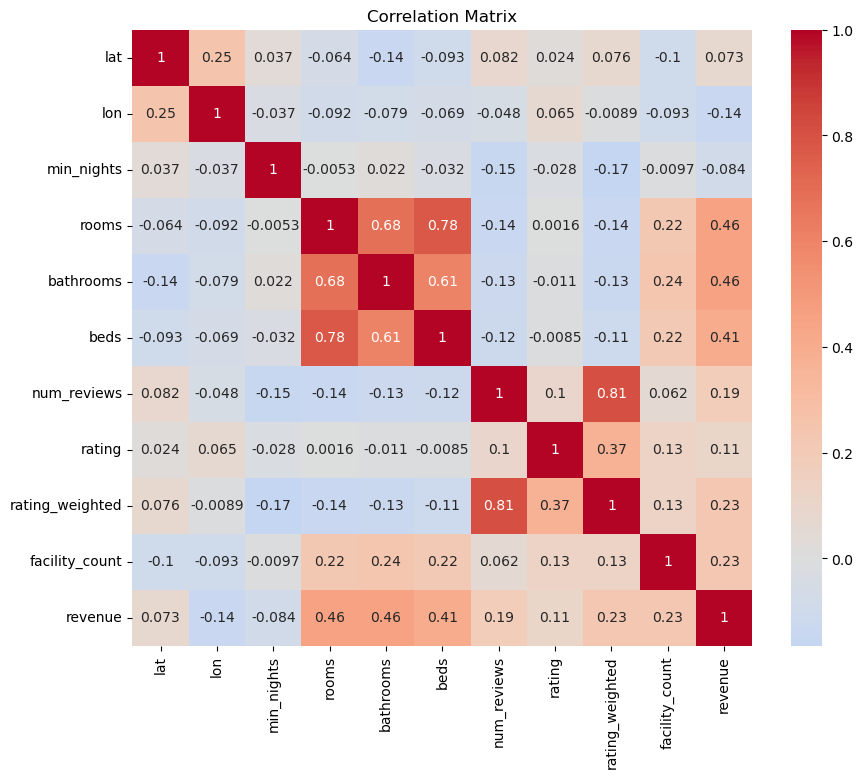

In [35]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)


plt.figure(figsize=(10, 8))
sns.heatmap(
    data=raw_train[['lat', 'lon','min_nights','rooms','bathrooms','beds', 
                    'num_reviews','rating', 'rating_weighted', 'facility_count', 'revenue']].corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title("Correlation Matrix")
plt.show()


In [36]:
for i in [raw_train, raw_valid]:
    i.drop(labels=['listing_type', 'facilities'], axis=1,inplace=True)

In [37]:
# Define target variable
target_col = 'revenue'

# Split raw_train into X and y
X_train = raw_train.drop(columns=[target_col])
y_train = raw_train[target_col]

# Split raw_valid into X and y
X_valid = raw_valid.drop(columns=[target_col])
y_valid = raw_valid[target_col]

# For log-transformed regression:
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)  # (optional, if needed for eval)

# Function Design

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
import pandas as pd

def make_preprocessor(imputation='simple', feature_set='basic'):
    # === Step 1: Define which features to use based on the feature_set ===
    if feature_set == 'basic':
        numeric_features = ['lat', 'lon']
        skewed_num = ['min_nights', 'rooms', 'bathrooms',
                            'beds', 'guests','num_reviews', 'rating']
        categorical_features = ['room_type', 'cancellation'
                               ]
    elif feature_set == 'engineered':
        numeric_features = ['lat', 'lon', 'rating_weighted',
                            'lat_lon_product', 'location_cluster']
        skewed_num = ['min_nights', 'rooms', 'bathrooms',
                            'beds', 'guests', 'num_reviews', 'rating']
        categorical_features = ['room_type', 'cancellation'
                               ]
    elif feature_set == 'engineered_reduced':
        numeric_features = ['rating_weighted', 'lat_lon_product', 'location_cluster']
        skewed_num = ['min_nights', 'rooms', 'bathrooms',
                            'beds', 'guests','num_reviews', 'rating']
        categorical_features = ['room_type', 'cancellation'
                               ]
    elif feature_set == 'mixed':
        numeric_features = ['lat', 'lon', 'rating_weighted', 'facility_count']
        skewed_num = ['min_nights', 'rooms', 'bathrooms',
                            'beds', 'guests','num_reviews', 'rating']
        categorical_features = ['room_type', 'cancellation'
                               ]
    else:
        raise ValueError("Invalid feature_set")

    # Store the list of all selected feature columns
    selected_features = numeric_features + skewed_num + categorical_features

    # === Step 2: Define the column selector ===
    # This function will slice the full DataFrame to only include selected columns
    def select_columns(X):
        return X[selected_features]

    # Wrap the column selector in a transformer so it can be used inside a pipeline
    selector = FunctionTransformer(select_columns)

    # Always define these so they exist when building the pipelines
    mean_imputer = SimpleImputer(strategy='mean')
    median_imputer = SimpleImputer(strategy='median')
    
    # Select imputer for the standard numeric pipeline
    if imputation == 'simple':
        num_imputer = mean_imputer
    elif imputation == 'knn':
        num_imputer = KNNImputer(n_neighbors=5)
    elif imputation == 'iterative':
        num_imputer = IterativeImputer(random_state=r_state)
    else:
        raise ValueError("Invalid imputation type")


    # # === Step 3: Choose numeric imputation strategy ===
    # if imputation == 'simple':
    #     mean_imputer = SimpleImputer(strategy='mean')
    #     median_imputer = SimpleImputer(strategy='median')
    # elif imputation == 'knn':
    #     num_imputer = KNNImputer(n_neighbors=5)
    # elif imputation == 'iterative':
    #     num_imputer = IterativeImputer(random_state=0)
    # else:
    #     raise ValueError("Invalid imputation type")

    # === Step 4: Build the pipelines for numeric and categorical preprocessing ===

    # Numeric pipeline: impute + scale
    numeric_pipeline = Pipeline(steps=[
        ('imputer', mean_imputer),
        ('scaler', StandardScaler())
    ])

    # Skewed Numeric pipeline: impute + log transform + scale
    skewed_num_pipeline = Pipeline(steps=[
        ('imputer', median_imputer),
        ('log', FunctionTransformer(np.log1p, validate=True)),
        ('scaler', StandardScaler())
    ])

    # Categorical pipeline: impute + one-hot encode
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # === Step 5: Combine pipelines using ColumnTransformer ===
    column_transform = ColumnTransformer(transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('skew', skewed_num_pipeline, skewed_num),
        ('cat', categorical_pipeline, categorical_features)
    ])

    # === Step 6: Wrap the column selector and transformer in a full pipeline ===
    # This ensures only the selected columns go into the preprocessor
    full_preprocessor = Pipeline(steps=[
        ('select', selector),
        ('transform', column_transform)
    ])

    # Optional: give it a name for logging
    preprocessor_name = f"{imputation}_{feature_set}"

    return full_preprocessor, preprocessor_name


In [40]:
def pipeline_iterator(model_type, imputation, feature_set, search_type=None, param_grid=None, n_iter=100, cv_folds=5):
    if search_type not in [None, 'grid', 'random']:
        raise ValueError("search_type must be None, 'grid', or 'random'.")

    if search_type in ['grid', 'random'] and param_grid is None:
        raise ValueError("param_grid must be provided for search_type='grid' or 'random'.")

    if search_type is None and param_grid is not None:
        logging.warning("param_grid is ignored since search_type is None.")

    # Instantiate model with random_state if possible
    try:
        model_instance = model_type(random_state=r_state)
    except TypeError:
        model_instance = model_type()

    # Define the pipeline
    preprocessor, preprocessor_name = make_preprocessor(imputation=imputation, feature_set=feature_set)
    logging.info(f"Using preprocessor: {preprocessor_name}")
    model_pipeline = make_pipeline(preprocessor, model_instance)


    # Select the estimator based on search_type
    if search_type == 'random':
        estimator = RandomizedSearchCV(
            estimator=model_pipeline,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=cv_folds,
            scoring='neg_mean_absolute_error',
            random_state=r_state,
            n_jobs=-1,
            verbose=1
        )
    elif search_type == 'grid':
        estimator = GridSearchCV(
            estimator=model_pipeline,
            param_grid=param_grid,
            cv=cv_folds,
            scoring='neg_mean_absolute_error',
            verbose=1
        )
    else:
        estimator = model_pipeline

    logging.info(f"Fitting model: {model_type.__name__} using {preprocessor_name} and search_type: {search_type or 'none'}")
    estimator.fit(X_train, y_train_log)

    # If using CV, get the best estimator
    if search_type in ['grid', 'random']:
        best_model = estimator.best_estimator_
        logging.info(f"Best params: {estimator.best_params_}")
    else:
        best_model = estimator

    # Predictions
    train_preds_log = best_model.predict(X_train)
    valid_preds_log = best_model.predict(X_valid)

    train_preds = np.expm1(train_preds_log)
    valid_preds = np.expm1(valid_preds_log)

    train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
    valid_mae = mean_absolute_error(y_valid, valid_preds)

    logging.info(f"{model_type.__name__} train MAE: {train_mae:.2f}")
    logging.info(f"{model_type.__name__} valid MAE: {valid_mae:.2f}")

    # return best_model

    return {
    'pipeline': estimator,  
    'train_mae': train_mae,
    'valid_mae': valid_mae,
    'mae_diff': abs(train_mae - valid_mae),
    'feature_set': feature_set  
        }



# Function Runs - Linear Models

In [42]:
imputation_types = ['simple','knn','iterative']
feature_sets = ['basic','engineered','engineered_reduced', 'mixed']

## Simple Linear Regression

In [44]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=LinearRegression,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 22:09:27,264 - INFO - Using preprocessor: simple_basic
2025-05-11 22:09:27,266 - INFO - Fitting model: LinearRegression using simple_basic and search_type: none
2025-05-11 22:09:27,314 - INFO - LinearRegression train MAE: 11116.10
2025-05-11 22:09:27,315 - INFO - LinearRegression valid MAE: 10894.71
2025-05-11 22:09:27,315 - INFO - Using preprocessor: simple_engineered
2025-05-11 22:09:27,315 - INFO - Fitting model: LinearRegression using simple_engineered and search_type: none
2025-05-11 22:09:27,363 - INFO - LinearRegression train MAE: 10793.90
2025-05-11 22:09:27,363 - INFO - LinearRegression valid MAE: 10567.83
2025-05-11 22:09:27,363 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 22:09:27,365 - INFO - Fitting model: LinearRegression using simple_engineered_reduced and search_type: none
2025-05-11 22:09:27,422 - INFO - LinearRegression train MAE: 10972.71
2025-05-11 22:09:27,422 - INFO - LinearRegression valid MAE: 10955.31
2025-05-11 22:09:27,422 - IN

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           10793.898595
valid_mae                                           10567.828446
mae_diff                                              226.070148
feature_set                                           engineered
imputation                                                simple
features                                              engineered
Name: 1, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           10972.711243
valid_mae                                           10955.308137
mae_diff                                               17.403106
feature_set                                   engineered_reduced
imputation                                                simple
features                                      engineered_reduced

## Lasso 

In [46]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=Lasso,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 22:09:27,940 - INFO - Using preprocessor: simple_basic
2025-05-11 22:09:27,941 - INFO - Fitting model: Lasso using simple_basic and search_type: none
2025-05-11 22:09:28,001 - INFO - Lasso train MAE: 14798.56
2025-05-11 22:09:28,001 - INFO - Lasso valid MAE: 14397.86
2025-05-11 22:09:28,001 - INFO - Using preprocessor: simple_engineered
2025-05-11 22:09:28,003 - INFO - Fitting model: Lasso using simple_engineered and search_type: none
2025-05-11 22:09:28,053 - INFO - Lasso train MAE: 14798.56
2025-05-11 22:09:28,054 - INFO - Lasso valid MAE: 14397.86
2025-05-11 22:09:28,054 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 22:09:28,055 - INFO - Fitting model: Lasso using simple_engineered_reduced and search_type: none
2025-05-11 22:09:28,103 - INFO - Lasso train MAE: 14798.56
2025-05-11 22:09:28,104 - INFO - Lasso valid MAE: 14397.86
2025-05-11 22:09:28,104 - INFO - Using preprocessor: simple_mixed
2025-05-11 22:09:28,104 - INFO - Fitting model: Lasso using s

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           14798.556994
valid_mae                                           14397.861409
mae_diff                                              400.695585
feature_set                                                basic
imputation                                                simple
features                                                   basic
Name: 0, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           14798.556994
valid_mae                                           14397.861409
mae_diff                                              400.695585
feature_set                                                basic
imputation                                                simple
features                                                   basic

## Ridge

In [48]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=Ridge,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 22:09:28,585 - INFO - Using preprocessor: simple_basic
2025-05-11 22:09:28,587 - INFO - Fitting model: Ridge using simple_basic and search_type: none
2025-05-11 22:09:28,651 - INFO - Ridge train MAE: 11116.04
2025-05-11 22:09:28,652 - INFO - Ridge valid MAE: 10894.32
2025-05-11 22:09:28,653 - INFO - Using preprocessor: simple_engineered
2025-05-11 22:09:28,653 - INFO - Fitting model: Ridge using simple_engineered and search_type: none
2025-05-11 22:09:28,723 - INFO - Ridge train MAE: 10793.97
2025-05-11 22:09:28,724 - INFO - Ridge valid MAE: 10568.20
2025-05-11 22:09:28,724 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 22:09:28,725 - INFO - Fitting model: Ridge using simple_engineered_reduced and search_type: none
2025-05-11 22:09:28,789 - INFO - Ridge train MAE: 10974.17
2025-05-11 22:09:28,790 - INFO - Ridge valid MAE: 10955.94
2025-05-11 22:09:28,790 - INFO - Using preprocessor: simple_mixed
2025-05-11 22:09:28,791 - INFO - Fitting model: Ridge using s

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           10793.966901
valid_mae                                           10568.203711
mae_diff                                               225.76319
feature_set                                           engineered
imputation                                                simple
features                                              engineered
Name: 1, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           10974.174598
valid_mae                                           10955.936859
mae_diff                                               18.237739
feature_set                                   engineered_reduced
imputation                                                simple
features                                      engineered_reduced

# Function Runs - Tree Models

## Random Forest

In [51]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=RandomForestRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 22:09:29,591 - INFO - Using preprocessor: simple_basic
2025-05-11 22:09:29,591 - INFO - Fitting model: RandomForestRegressor using simple_basic and search_type: none
2025-05-11 22:09:33,727 - INFO - RandomForestRegressor train MAE: 4081.51
2025-05-11 22:09:33,727 - INFO - RandomForestRegressor valid MAE: 9345.18
2025-05-11 22:09:33,728 - INFO - Using preprocessor: simple_engineered
2025-05-11 22:09:33,728 - INFO - Fitting model: RandomForestRegressor using simple_engineered and search_type: none
2025-05-11 22:09:39,266 - INFO - RandomForestRegressor train MAE: 4045.29
2025-05-11 22:09:39,266 - INFO - RandomForestRegressor valid MAE: 9397.06
2025-05-11 22:09:39,268 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 22:09:39,268 - INFO - Fitting model: RandomForestRegressor using simple_engineered_reduced and search_type: none
2025-05-11 22:09:43,417 - INFO - RandomForestRegressor train MAE: 4273.16
2025-05-11 22:09:43,418 - INFO - RandomForestRegressor valid MA

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            4081.513875
valid_mae                                            9345.175602
mae_diff                                             5263.661727
feature_set                                                basic
imputation                                                simple
features                                                   basic
Name: 0, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            4081.513875
valid_mae                                            9345.175602
mae_diff                                             5263.661727
feature_set                                                basic
imputation                                                simple
features                                                   basic

### With RandomizedSearchCV

In [53]:
param_grid_rf = {
    'randomforestregressor__max_depth': [None, 10, 20, 30, 40, 50],
    'randomforestregressor__n_estimators': [50, 100, 200, 300, 400, 500],
    'randomforestregressor__min_samples_split': [2, 5, 10, 20]
}

best_rf = pipeline_iterator(
            model_type=RandomForestRegressor,
            imputation='simple',
            feature_set='basic',
            search_type='random',
            param_grid=param_grid_rf,
            n_iter=50,
            cv_folds=5
        )

2025-05-11 22:10:25,946 - INFO - Using preprocessor: simple_basic
2025-05-11 22:10:25,947 - INFO - Fitting model: RandomForestRegressor using simple_basic and search_type: random


Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-05-11 22:13:18,452 - INFO - Best params: {'randomforestregressor__n_estimators': 300, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__max_depth': 50}
2025-05-11 22:13:18,858 - INFO - RandomForestRegressor train MAE: 5956.85
2025-05-11 22:13:18,859 - INFO - RandomForestRegressor valid MAE: 9330.68


### Feature Importance

In [59]:
def get_selected_features(feature_set):
    if feature_set == 'basic':
        return ['lat', 'lon', 'min_nights', 'rooms', 'bathrooms', 'beds', 'guests',
                'num_reviews', 'rating', 'room_type', 'cancellation'
               ]
    elif feature_set == 'engineered':
        return ['lat', 'lon', 'min_nights', 'rooms', 'bathrooms', 'beds', 'guests', 'num_reviews',
                'rating', 'rating_weighted', 'lat_lon_product', 'location_cluster',
                'room_type', 'cancellation'
               ]
    elif feature_set == 'engineered_reduced':
        return ['min_nights', 'rooms', 'bathrooms', 'beds', 'guests','rating_weighted',
                'lat_lon_product', 'location_cluster', 'room_type', 'cancellation'
               ]
    elif feature_set == 'mixed':
        return ['lat', 'lon', 'min_nights', 'rooms', 'bathrooms', 'beds', 'guests',
                'num_reviews', 'rating', 'rating_weighted', 'facility_count',
                'room_type', 'cancellation'
               ]
    else:
        raise ValueError("Invalid feature_set")


In [61]:
feature_set_used = best_rf['feature_set']
selected_features = get_selected_features(feature_set_used)
X_val_filtered = X_valid[selected_features]


In [63]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=best_rf['pipeline'],
    X=X_val_filtered,
    y=y_valid_log,  
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

importances_df = pd.DataFrame({
    'feature': X_val_filtered.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head(15))


         feature  importance_mean  importance_std
7    num_reviews         0.194696        0.005073
1            lon         0.165494        0.004452
3          rooms         0.074735        0.002756
0            lat         0.069531        0.003231
8         rating         0.054352        0.004902
9      room_type         0.046317        0.002245
4      bathrooms         0.030452        0.001952
6         guests         0.008705        0.000991
2     min_nights         0.008029        0.001157
5           beds         0.007504        0.000965
10  cancellation         0.003411        0.000415


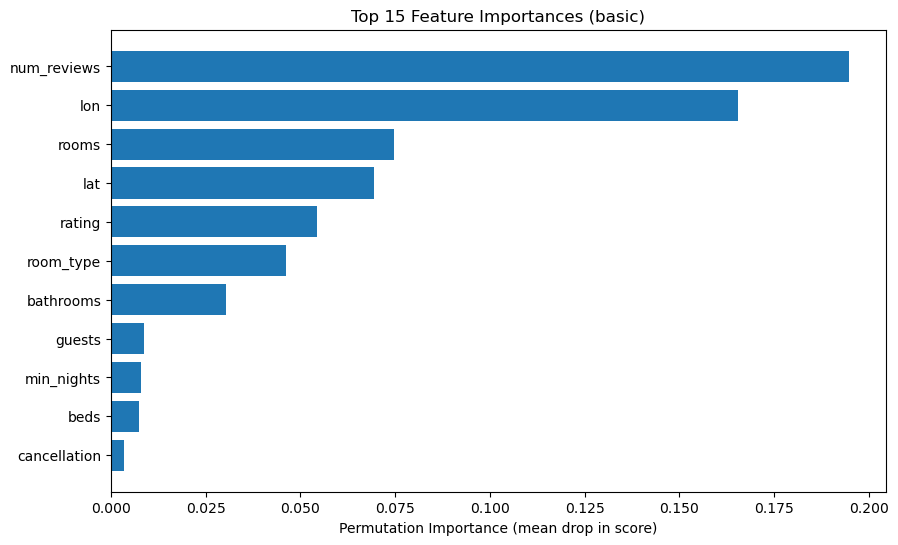

In [65]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15), importances_df['importance_mean'].head(15))
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title(f"Top 15 Feature Importances ({feature_set_used})")
plt.gca().invert_yaxis()
plt.show()


## GradientBoostingRegressor

In [67]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=GradientBoostingRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 22:16:28,961 - INFO - Using preprocessor: simple_basic
2025-05-11 22:16:28,961 - INFO - Fitting model: GradientBoostingRegressor using simple_basic and search_type: none
2025-05-11 22:16:30,096 - INFO - GradientBoostingRegressor train MAE: 9510.64
2025-05-11 22:16:30,096 - INFO - GradientBoostingRegressor valid MAE: 9511.87
2025-05-11 22:16:30,097 - INFO - Using preprocessor: simple_engineered
2025-05-11 22:16:30,097 - INFO - Fitting model: GradientBoostingRegressor using simple_engineered and search_type: none
2025-05-11 22:16:31,662 - INFO - GradientBoostingRegressor train MAE: 9466.06
2025-05-11 22:16:31,663 - INFO - GradientBoostingRegressor valid MAE: 9580.27
2025-05-11 22:16:31,664 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 22:16:31,664 - INFO - Fitting model: GradientBoostingRegressor using simple_engineered_reduced and search_type: none
2025-05-11 22:16:32,770 - INFO - GradientBoostingRegressor train MAE: 9792.73
2025-05-11 22:16:32,771 - INFO 

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            9434.477016
valid_mae                                            9374.596767
mae_diff                                               59.880249
feature_set                                                mixed
imputation                                                simple
features                                                   mixed
Name: 3, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            9510.638866
valid_mae                                            9511.867042
mae_diff                                                1.228175
feature_set                                                basic
imputation                                                simple
features                                                   basic

### With RandomizedSearchCV

In [69]:
param_grid_gbr = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    #'gradientboostingregressor__loss': ['absolute_error', 'squared_error', 'huber', 'quantile']
}

best_gbr = pipeline_iterator(
            model_type=GradientBoostingRegressor,
            imputation='simple',
            feature_set='mixed',
            search_type='random',
            param_grid=param_grid_gbr,
            n_iter=100,
            cv_folds=5
        )

2025-05-11 22:16:44,670 - INFO - Using preprocessor: simple_mixed
2025-05-11 22:16:44,670 - INFO - Fitting model: GradientBoostingRegressor using simple_mixed and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-11 22:17:34,649 - INFO - Best params: {'gradientboostingregressor__subsample': 0.8, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__min_samples_leaf': 4, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
2025-05-11 22:17:34,704 - INFO - GradientBoostingRegressor train MAE: 7459.99
2025-05-11 22:17:34,705 - INFO - GradientBoostingRegressor valid MAE: 8714.16


### Feature Importance

In [71]:
feature_set_used = best_gbr['feature_set']
selected_features = get_selected_features(feature_set_used)
X_val_filtered = X_valid[selected_features]


In [72]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=best_gbr['pipeline'],
    X=X_val_filtered,
    y=y_valid_log,  
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

importances_df = pd.DataFrame({
    'feature': X_val_filtered.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head(15))


            feature  importance_mean  importance_std
1               lon         0.187651        0.004054
9   rating_weighted         0.156700        0.003533
0               lat         0.094074        0.004570
3             rooms         0.043896        0.001815
8            rating         0.042539        0.003420
11        room_type         0.035336        0.002005
4         bathrooms         0.028278        0.001372
6            guests         0.013855        0.001590
7       num_reviews         0.013816        0.001296
2        min_nights         0.008914        0.001247
10   facility_count         0.007808        0.001565
12     cancellation         0.004853        0.001020
5              beds         0.004296        0.000750


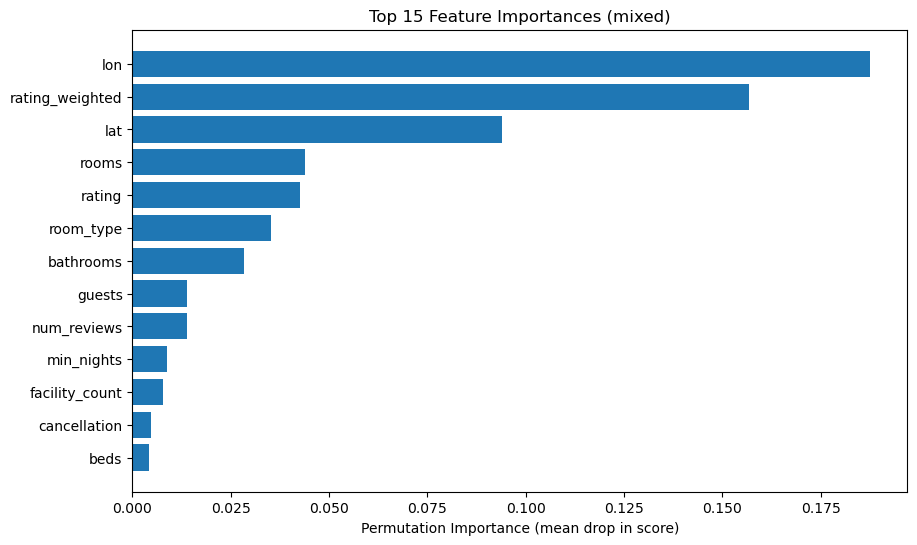

In [73]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15), importances_df['importance_mean'].head(15))
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title(f"Top 15 Feature Importances ({feature_set_used})")
plt.gca().invert_yaxis()
plt.show()


## HistGradientBoostingRegresor

In [75]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=HistGradientBoostingRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 22:17:35,322 - INFO - Using preprocessor: simple_basic
2025-05-11 22:17:35,322 - INFO - Fitting model: HistGradientBoostingRegressor using simple_basic and search_type: none
2025-05-11 22:17:35,546 - INFO - HistGradientBoostingRegressor train MAE: 8107.75
2025-05-11 22:17:35,547 - INFO - HistGradientBoostingRegressor valid MAE: 8813.51
2025-05-11 22:17:35,547 - INFO - Using preprocessor: simple_engineered
2025-05-11 22:17:35,548 - INFO - Fitting model: HistGradientBoostingRegressor using simple_engineered and search_type: none
2025-05-11 22:17:35,768 - INFO - HistGradientBoostingRegressor train MAE: 8149.66
2025-05-11 22:17:35,769 - INFO - HistGradientBoostingRegressor valid MAE: 8857.96
2025-05-11 22:17:35,769 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 22:17:35,770 - INFO - Fitting model: HistGradientBoostingRegressor using simple_engineered_reduced and search_type: none
2025-05-11 22:17:35,961 - INFO - HistGradientBoostingRegressor train MAE: 8531.18

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            8059.325377
valid_mae                                            8780.335418
mae_diff                                              721.010041
feature_set                                                mixed
imputation                                                simple
features                                                   mixed
Name: 3, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            8107.753524
valid_mae                                            8813.507641
mae_diff                                              705.754117
feature_set                                                basic
imputation                                                simple
features                                                   basic

### With RandomizedSearchCV

In [77]:
param_grid_hgbr =  {
    'histgradientboostingregressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300, 500],  # like n_estimators
    'histgradientboostingregressor__max_depth': [None, 5, 10, 20],     # controls tree depth
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50, 100],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 0.5, 1.0, 5.0],
    'histgradientboostingregressor__max_leaf_nodes': [15, 31, 63],     # cap on tree complexity
    'histgradientboostingregressor__early_stopping': [False],          # we control stopping manually
    'histgradientboostingregressor__scoring': [None],                  # uses loss, not validation metric
    'histgradientboostingregressor__monotonic_cst': [None],            # can later test constraints
    'histgradientboostingregressor__categorical_features': [None], 
}

best_hgbr = pipeline_iterator(
            model_type=HistGradientBoostingRegressor,
            imputation='simple',
            feature_set='mixed',
            search_type='random',
            param_grid=param_grid_hgbr,
            n_iter=100,
            cv_folds=5
        )

2025-05-11 22:17:38,111 - INFO - Using preprocessor: simple_mixed
2025-05-11 22:17:38,112 - INFO - Fitting model: HistGradientBoostingRegressor using simple_mixed and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-11 22:18:17,903 - INFO - Best params: {'histgradientboostingregressor__scoring': None, 'histgradientboostingregressor__monotonic_cst': None, 'histgradientboostingregressor__min_samples_leaf': 10, 'histgradientboostingregressor__max_leaf_nodes': 31, 'histgradientboostingregressor__max_iter': 500, 'histgradientboostingregressor__max_depth': None, 'histgradientboostingregressor__learning_rate': 0.05, 'histgradientboostingregressor__l2_regularization': 5.0, 'histgradientboostingregressor__early_stopping': False, 'histgradientboostingregressor__categorical_features': None}
2025-05-11 22:18:18,030 - INFO - HistGradientBoostingRegressor train MAE: 6919.33
2025-05-11 22:18:18,031 - INFO - HistGradientBoostingRegressor valid MAE: 8684.33


### Feature Importance

In [79]:
feature_set_used = best_hgbr['feature_set']
selected_features = get_selected_features(feature_set_used)
X_val_filtered = X_valid[selected_features]


In [80]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=best_hgbr['pipeline'],
    X=X_val_filtered,
    y=y_valid_log,  # or y_valid if you're not using log transform
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

importances_df = pd.DataFrame({
    'feature': X_val_filtered.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head(15))


            feature  importance_mean  importance_std
1               lon         0.183154        0.004262
9   rating_weighted         0.143567        0.004090
0               lat         0.094387        0.004355
3             rooms         0.039057        0.002152
11        room_type         0.038739        0.001970
8            rating         0.037059        0.003811
4         bathrooms         0.025617        0.001850
6            guests         0.017696        0.001576
2        min_nights         0.011138        0.000920
7       num_reviews         0.010157        0.001506
10   facility_count         0.008372        0.001816
12     cancellation         0.005302        0.001141
5              beds         0.005011        0.000741


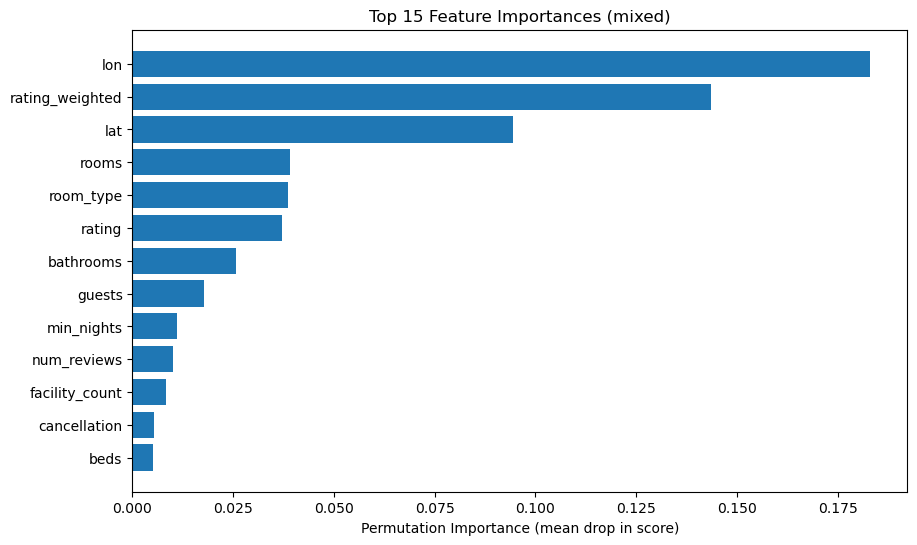

In [81]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15), importances_df['importance_mean'].head(15))
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title(f"Top 15 Feature Importances ({feature_set_used})")
plt.gca().invert_yaxis()
plt.show()


## XGBoost

In [83]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=XGBRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 22:18:21,048 - INFO - Using preprocessor: simple_basic
2025-05-11 22:18:21,050 - INFO - Fitting model: XGBRegressor using simple_basic and search_type: none
2025-05-11 22:18:21,386 - INFO - XGBRegressor train MAE: 6233.04
2025-05-11 22:18:21,387 - INFO - XGBRegressor valid MAE: 9117.52
2025-05-11 22:18:21,387 - INFO - Using preprocessor: simple_engineered
2025-05-11 22:18:21,387 - INFO - Fitting model: XGBRegressor using simple_engineered and search_type: none
2025-05-11 22:18:21,536 - INFO - XGBRegressor train MAE: 6092.44
2025-05-11 22:18:21,537 - INFO - XGBRegressor valid MAE: 10608.11
2025-05-11 22:18:21,538 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 22:18:21,538 - INFO - Fitting model: XGBRegressor using simple_engineered_reduced and search_type: none
2025-05-11 22:18:21,675 - INFO - XGBRegressor train MAE: 6418.84
2025-05-11 22:18:21,675 - INFO - XGBRegressor valid MAE: 9917.26
2025-05-11 22:18:21,676 - INFO - Using preprocessor: simple_mixed
202

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            5966.909668
valid_mae                                            9058.544922
mae_diff                                             3091.635254
feature_set                                                mixed
imputation                                                simple
features                                                   mixed
Name: 3, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            6233.038086
valid_mae                                            9117.519531
mae_diff                                             2884.481445
feature_set                                                basic
imputation                                                simple
features                                                   basic

### With RandomizedSearchCV

In [85]:
param_grid_xgb = {
    'xgbregressor__n_estimators': [100, 200, 300, 400],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6, 8],
    'xgbregressor__min_child_weight': [1, 3, 5, 7],
    'xgbregressor__gamma': [0, 0.1, 0.3, 0.5],  # minimum loss reduction for a split
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1.0],  # L1 regularization
    'xgbregressor__reg_lambda': [1.0, 1.5, 2.0],     # L2 regularization
    #'xgbregressor__booster': ['gbtree', 'dart'],     # 'gblinear' is not ideal for tabular
    #'xgbregressor__max_delta_step': [0, 1, 5]        # for better convergence in imbalanced cases
}

best_xgb = pipeline_iterator(
            model_type=XGBRegressor,
            imputation='simple',
            feature_set='mixed',
            search_type='random',
            param_grid=param_grid_xgb,
            n_iter=100,
            cv_folds=5
        )

2025-05-11 22:18:22,731 - INFO - Using preprocessor: simple_mixed
2025-05-11 22:18:22,732 - INFO - Fitting model: XGBRegressor using simple_mixed and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-11 22:18:43,058 - INFO - Best params: {'xgbregressor__subsample': 0.8, 'xgbregressor__reg_lambda': 1.5, 'xgbregressor__reg_alpha': 0.1, 'xgbregressor__n_estimators': 300, 'xgbregressor__min_child_weight': 5, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__gamma': 0.3, 'xgbregressor__colsample_bytree': 0.6}
2025-05-11 22:18:43,103 - INFO - XGBRegressor train MAE: 7406.08
2025-05-11 22:18:43,104 - INFO - XGBRegressor valid MAE: 8669.02


### Feature Importance

In [87]:
feature_set_used = best_xgb['feature_set']
selected_features = get_selected_features(feature_set_used)
X_val_filtered = X_valid[selected_features]


In [88]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=best_xgb['pipeline'],
    X=X_val_filtered,
    y=y_valid_log,  # or y_valid if you're not using log transform
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

importances_df = pd.DataFrame({
    'feature': X_val_filtered.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head(15))


            feature  importance_mean  importance_std
1               lon         0.181985        0.004127
9   rating_weighted         0.106183        0.003844
0               lat         0.085348        0.003683
8            rating         0.042026        0.003410
11        room_type         0.039626        0.002341
3             rooms         0.031067        0.001847
4         bathrooms         0.025792        0.001230
7       num_reviews         0.020078        0.001941
6            guests         0.014651        0.001233
2        min_nights         0.010117        0.000976
10   facility_count         0.007374        0.001048
12     cancellation         0.005116        0.000877
5              beds         0.002660        0.000620


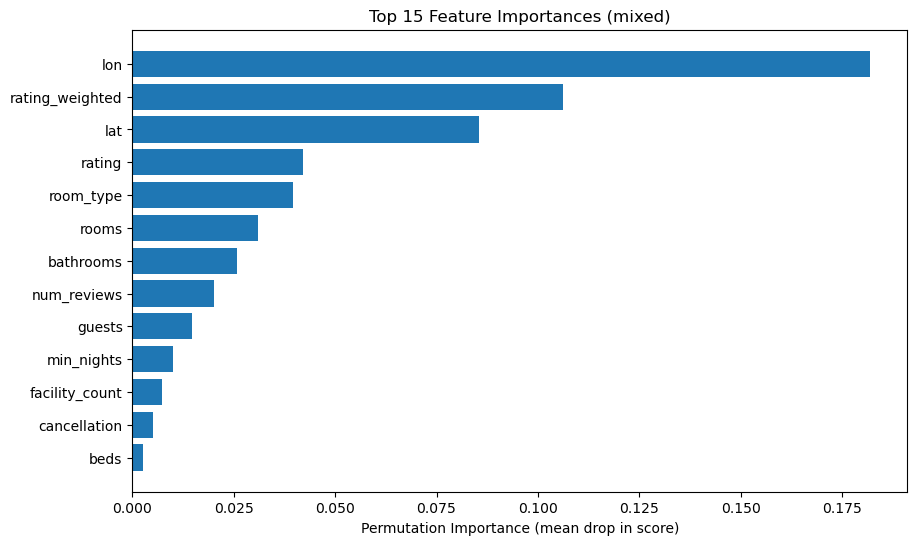

In [89]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15), importances_df['importance_mean'].head(15))
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title(f"Top 15 Feature Importances ({feature_set_used})")
plt.gca().invert_yaxis()
plt.show()


## LightGBM

In [91]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=LGBMRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 22:18:44,236 - INFO - Using preprocessor: simple_basic
2025-05-11 22:18:44,237 - INFO - Fitting model: LGBMRegressor using simple_basic and search_type: none


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 19
[LightGBM] [Info] Start training from score 9.469813


2025-05-11 22:18:44,369 - INFO - LGBMRegressor train MAE: 8103.92
2025-05-11 22:18:44,369 - INFO - LGBMRegressor valid MAE: 8782.95
2025-05-11 22:18:44,370 - INFO - Using preprocessor: simple_engineered
2025-05-11 22:18:44,370 - INFO - Fitting model: LGBMRegressor using simple_engineered and search_type: none
2025-05-11 22:18:44,478 - INFO - LGBMRegressor train MAE: 8064.20


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1475
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 22
[LightGBM] [Info] Start training from score 9.469813


2025-05-11 22:18:44,478 - INFO - LGBMRegressor valid MAE: 8929.44
2025-05-11 22:18:44,479 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 22:18:44,479 - INFO - Fitting model: LGBMRegressor using simple_engineered_reduced and search_type: none
2025-05-11 22:18:44,573 - INFO - LGBMRegressor train MAE: 8459.59
2025-05-11 22:18:44,573 - INFO - LGBMRegressor valid MAE: 9634.41


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 20
[LightGBM] [Info] Start training from score 9.469813


2025-05-11 22:18:44,574 - INFO - Using preprocessor: simple_mixed
2025-05-11 22:18:44,574 - INFO - Fitting model: LGBMRegressor using simple_mixed and search_type: none
2025-05-11 22:18:44,675 - INFO - LGBMRegressor train MAE: 8021.65
2025-05-11 22:18:44,676 - INFO - LGBMRegressor valid MAE: 8801.31
2025-05-11 22:18:44,676 - INFO - Using preprocessor: knn_basic
2025-05-11 22:18:44,677 - INFO - Fitting model: LGBMRegressor using knn_basic and search_type: none


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 21
[LightGBM] [Info] Start training from score 9.469813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 19
[LightGBM] [Info] Start training from score 9.469813


2025-05-11 22:18:44,776 - INFO - LGBMRegressor train MAE: 8103.92
2025-05-11 22:18:44,776 - INFO - LGBMRegressor valid MAE: 8782.95
2025-05-11 22:18:44,777 - INFO - Using preprocessor: knn_engineered
2025-05-11 22:18:44,778 - INFO - Fitting model: LGBMRegressor using knn_engineered and search_type: none
2025-05-11 22:18:44,895 - INFO - LGBMRegressor train MAE: 8064.20
2025-05-11 22:18:44,896 - INFO - LGBMRegressor valid MAE: 8929.44
2025-05-11 22:18:44,896 - INFO - Using preprocessor: knn_engineered_reduced
2025-05-11 22:18:44,897 - INFO - Fitting model: LGBMRegressor using knn_engineered_reduced and search_type: none


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1475
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 22
[LightGBM] [Info] Start training from score 9.469813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 20
[LightGBM] [Info] Start training from score 9.469813


2025-05-11 22:18:44,996 - INFO - LGBMRegressor train MAE: 8459.59
2025-05-11 22:18:44,996 - INFO - LGBMRegressor valid MAE: 9634.41
2025-05-11 22:18:44,997 - INFO - Using preprocessor: knn_mixed
2025-05-11 22:18:44,997 - INFO - Fitting model: LGBMRegressor using knn_mixed and search_type: none
2025-05-11 22:18:45,119 - INFO - LGBMRegressor train MAE: 8021.65
2025-05-11 22:18:45,119 - INFO - LGBMRegressor valid MAE: 8801.31
2025-05-11 22:18:45,119 - INFO - Using preprocessor: iterative_basic
2025-05-11 22:18:45,120 - INFO - Fitting model: LGBMRegressor using iterative_basic and search_type: none


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 21
[LightGBM] [Info] Start training from score 9.469813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 19
[LightGBM] [Info] Start training from score 9.469813


2025-05-11 22:18:45,240 - INFO - LGBMRegressor train MAE: 8103.92
2025-05-11 22:18:45,241 - INFO - LGBMRegressor valid MAE: 8782.95
2025-05-11 22:18:45,241 - INFO - Using preprocessor: iterative_engineered
2025-05-11 22:18:45,242 - INFO - Fitting model: LGBMRegressor using iterative_engineered and search_type: none
2025-05-11 22:18:45,349 - INFO - LGBMRegressor train MAE: 8064.20
2025-05-11 22:18:45,350 - INFO - LGBMRegressor valid MAE: 8929.44
2025-05-11 22:18:45,350 - INFO - Using preprocessor: iterative_engineered_reduced
2025-05-11 22:18:45,351 - INFO - Fitting model: LGBMRegressor using iterative_engineered_reduced and search_type: none
2025-05-11 22:18:45,448 - INFO - LGBMRegressor train MAE: 8459.59


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1475
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 22
[LightGBM] [Info] Start training from score 9.469813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 20
[LightGBM] [Info] Start training from score 9.469813


2025-05-11 22:18:45,449 - INFO - LGBMRegressor valid MAE: 9634.41
2025-05-11 22:18:45,450 - INFO - Using preprocessor: iterative_mixed
2025-05-11 22:18:45,450 - INFO - Fitting model: LGBMRegressor using iterative_mixed and search_type: none
2025-05-11 22:18:45,551 - INFO - LGBMRegressor train MAE: 8021.65
2025-05-11 22:18:45,552 - INFO - LGBMRegressor valid MAE: 8801.31


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 10178, number of used features: 21
[LightGBM] [Info] Start training from score 9.469813
🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            8103.916443
valid_mae                                            8782.952659
mae_diff                                              679.036216
feature_set                                                basic
imputation                                                simple
features                                                   basic
Name: 0, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                      

### With RandomizedSearchCV

In [93]:
param_grid_lgbm = {
    'lgbmregressor__n_estimators': [100, 200, 500],
    'lgbmregressor__learning_rate': [0.01, 0.05, 0.1],
    'lgbmregressor__max_depth': [-1, 6, 10],
    #'lgbmregressor__num_leaves': [31, 63, 127, 255],
    #'lgbmregressor__min_child_samples': [1, 5, 10, 20],
    'lgbmregressor__subsample': [0.6, 0.8, 1.0],
    'lgbmregressor__colsample_bytree': [0.6, 0.8, 1.0],
    #'lgbmregressor__reg_alpha': [0.0, 0.01, 0.1, 0.5],
    #'lgbmregressor__reg_lambda': [0.0, 0.01, 0.1, 0.5],
    #'lgbmregressor__min_split_gain': [0.0, 0.001, 0.01]
}

# param_grid_lgbm = {
#     'lgbmregressor__n_estimators': [100, 200, 300, 500],
#     'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'lgbmregressor__max_depth': [-1, 4, 6, 8, 10],
#     'lgbmregressor__num_leaves': [15, 31, 63, 127],
#     'lgbmregressor__min_child_samples': [5, 10, 20, 50],
#     'lgbmregressor__subsample': [0.6, 0.8, 1.0],
#     'lgbmregressor__colsample_bytree': [0.6, 0.8, 1.0],
#     'lgbmregressor__reg_alpha': [0.0, 0.1, 0.5, 1.0],
#     'lgbmregressor__reg_lambda': [0.0, 0.1, 0.5, 1.0]
# }

best_lgbm = pipeline_iterator(
            model_type=LGBMRegressor,
            imputation='knn',
            feature_set='mixed',
            search_type='random',
            param_grid=param_grid_lgbm,
            n_iter=50,
            cv_folds=5
        )

2025-05-11 22:18:45,597 - INFO - Using preprocessor: knn_mixed
2025-05-11 22:18:45,598 - INFO - Fitting model: LGBMRegressor using knn_mixed and search_type: random


Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

### Feature Importance

In [ ]:
feature_set_used = best_lgbm['feature_set']
selected_features = get_selected_features(feature_set_used)
X_val_filtered = X_valid[selected_features]


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=best_lgbm['pipeline'],
    X=X_val_filtered,
    y=y_valid_log,  # or y_valid if you're not using log transform
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

importances_df = pd.DataFrame({
    'feature': X_val_filtered.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head(15))


In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15), importances_df['importance_mean'].head(15))
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title(f"Top 15 Feature Importances ({feature_set_used})")
plt.gca().invert_yaxis()
plt.show()


# Voting Regressor

In [109]:
# Combine fitted pipelines into a voting regressor
voting_model = VotingRegressor(estimators=[
    ('gbr', best_gbr['pipeline']),
    ('xgb', best_xgb['pipeline']),
    ('hgb', best_hgbr['pipeline']),
    #('lgbm', best_lgbm['pipeline'])
])


voting_model.fit(X_train, y_train_log)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


VotingRegressor(estimators=[('gbr',
                             RandomizedSearchCV(cv=5,
                                                estimator=Pipeline(steps=[('pipeline',
                                                                           Pipeline(steps=[('select',
                                                                                            FunctionTransformer(func=<function make_preprocessor.<locals>.select_columns at 0x000001A279E0A020>)),
                                                                                           ('transform',
                                                                                            ColumnTransformer(transformers=[('num',
                                                                                                                             Pipeline(steps=[('imputer',
                                                                                                                                              SimpleImputer()),
                                                                                                                                             ('scaler',
                                                                                                                                              StandardScaler())]),
                                                                                                                             ['...
                                                                     'histgradientboostingregressor__max_iter': [100,
                                                                                                                 200,
                                                                                                                 300,
                                                                                                                 500],
                                                                     'histgradientboostingregressor__max_leaf_nodes': [15,
                                                                                                                       31,
                                                                                                                       63],
                                                                     'histgradientboostingregressor__min_samples_leaf': [10,
                                                                                                                         20,
                                                                                                                         50,
                                                                                                                         100],
                                                                     'histgradientboostingregressor__monotonic_cst': [None],
                                                                     'histgradientboostingregressor__scoring': [None]},
                                                random_state=123,
                                                scoring='neg_mean_absolute_error',
                                                verbose=1))])

In [111]:

train_preds_log = voting_model.predict(X_train)
valid_preds_log = voting_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"VotingRegressor Train MAE: {train_mae:.2f}")
print(f"VotingRegressor Valid MAE: {valid_mae:.2f}")
print(f"VotingRegressor MAE diff: {valid_mae - train_mae:2f}")


VotingRegressor Train MAE: 7192.41
VotingRegressor Valid MAE: 8600.02
VotingRegressor MAE diff: 1407.608527


# Model Stacking

In [ ]:
from sklearn.ensemble import StackingRegressor

# 1. Define the stacking regressor (base models already fitted pipelines)
stack = StackingRegressor(
    estimators=[
        #('lgbm', best_lgbm['pipeline']),
        ('xgb', best_xgb['pipeline']),
        ('hgbr', best_hgbr['pipeline']),
        #('gbr', best_gbr['pipeline']),
    ],
    final_estimator=Ridge(alpha=10),        # Meta-model to tune
    passthrough=False,              # Set True if you want to include original features too
    n_jobs=-1,
    cv=3
)

# 2. Define parameter grid to tune Ridge alpha
# param_grid = {
#     'final_estimator__alpha': [0.01, 0.1, 1, 10, 100]
# }

# # 3. Run grid search to tune final estimator
# search = GridSearchCV(
#     estimator=stack,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# 4. Fit the stacked model on training data
# search.fit(X_train, y_train_log)
stack.fit(X_train, y_train_log)

# 5. View best alpha and CV score
# print(f"Best alpha for Ridge meta-model: {search.best_params_['final_estimator__alpha']}")
# print(f"Best cross-validated MAE: {-search.best_score_:.2f}")

# # 6. Evaluate on validation set
# stacked_best = search.best_estimator_
# preds_log = stacked_best.predict(X_valid)
preds_log = stack.predict(X_valid)
preds = np.expm1(preds_log)
mae = mean_absolute_error(y_valid, preds)
print(f"Validation MAE for best stacked model: {mae:.2f}")



In [ ]:
# Predict log-transformed outputs
train_preds_log = stack.predict(X_train)
valid_preds_log = stack.predict(X_valid)

# Inverse transform to original scale
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate MAE
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"StackingRegressor Train MAE: {train_mae:.2f}")
print(f"StackingRegressor Valid MAE: {valid_mae:.2f}")

# OLD !!

## Gradient Boosted Regressor

## Baseline

In [ ]:

gbr_model = make_pipeline(
    preprocess1,
    GradientBoostingRegressor(random_state=r_state)
)

gbr_model.fit(X_train, y_train_log)


train_preds_log = gbr_model.predict(X_train)
valid_preds_log = gbr_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Gradient Boosting Train MAE: {train_mae:.2f}")
logging.info(f"Gradient Boosting Valid MAE: {valid_mae:.2f}")

## GBR RandomSearch

### Selected for voting

In [ ]:
# Define the pipeline with SimpleImputer
gbr_pipeline = make_pipeline(
    preprocess1,
    GradientBoostingRegressor(random_state=r_state)
)

# Define parameter grid for randomized search
param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    #'gradientboostingregressor__loss': ['absolute_error', 'squared_error', 'huber', 'quantile']
}


# Step 4: Run randomized search
random_search = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

random_search.fit(X_train, y_train_log)  # fit on log-transformed target

# Step 5: Get best estimator and make predictions
best_gbr_model1 = random_search.best_estimator_

train_preds_log = best_gbr_model1.predict(X_train)
valid_preds_log = best_gbr_model1.predict(X_valid)

# Step 6: Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Step 7: Evaluate using original targets
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"RandomForest MAE on train set: {train_mae:.2f}")
logging.info(f"RandomForest MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

## !Testing!

In [ ]:
# Define the pipeline with SimpleImputer
gbr_pipeline = make_pipeline(
    preprocess_guests,
    GradientBoostingRegressor(random_state=r_state)
)

# Define parameter grid for randomized search
param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    #'gradientboostingregressor__loss': ['absolute_error', 'squared_error', 'huber', 'quantile']
}


# Step 4: Run randomized search
random_search = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

random_search.fit(X_train, y_train_log)  # fit on log-transformed target

# Step 5: Get best estimator and make predictions
best_gbr_model2 = random_search.best_estimator_

train_preds_log = best_gbr_model2.predict(X_train)
valid_preds_log = best_gbr_model2.predict(X_valid)

# Step 6: Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Step 7: Evaluate using original targets
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"RandomForest MAE on train set: {train_mae:.2f}")
logging.info(f"RandomForest MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

## XGBoost

## Baseline

In [ ]:
from xgboost import XGBRegressor

xgb_model = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

xgb_model.fit(X_train, y_train_log)


train_preds_log = xgb_model.predict(X_train)
valid_preds_log = xgb_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Gradient Boosting Train MAE: {train_mae:.2f}")
logging.info(f"Gradient Boosting Valid MAE: {valid_mae:.2f}")

## XGB RandomSearch

In [ ]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [50, 100, 200, 300],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6],
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__min_child_weight': [1, 3, 5]
}

# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model = random_search.best_estimator_

train_preds_log = best_xgb_model.predict(X_train)
valid_preds_log = best_xgb_model.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

## !Testing!

### Selected for voting

In [ ]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300, 400],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6, 8],
    'xgbregressor__min_child_weight': [1, 3, 5, 7],
    'xgbregressor__gamma': [0, 0.1, 0.3, 0.5],  # minimum loss reduction for a split
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1.0],  # L1 regularization
    'xgbregressor__reg_lambda': [1.0, 1.5, 2.0],     # L2 regularization
    #'xgbregressor__booster': ['gbtree', 'dart'],     # 'gblinear' is not ideal for tabular
    #'xgbregressor__max_delta_step': [0, 1, 5]        # for better convergence in imbalanced cases
}


# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model1 = random_search.best_estimator_

train_preds_log = best_xgb_model1.predict(X_train)
valid_preds_log = best_xgb_model1.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Use raw X_train (NOT transformed — the pipeline handles that)
PartialDependenceDisplay.from_estimator(
    best_xgb_model,                # your full fitted pipeline
    X_train,                       # raw features with column names
    features=['rooms', 'min_nights', 'rating', 'num_reviews', 'lat', 'lon', 'bathrooms', 'beds'],  # any continuous feature names
    kind='average',
    grid_resolution=30
)
plt.show()




In [ ]:
# Turn search results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Convert the score to positive MAE
results['mae'] = -results['mean_test_score']

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(results['param_xgbregressor__max_depth'], results['mae'])
plt.xlabel('max_depth')
plt.ylabel('Validation MAE')
plt.title('Effect of max_depth on MAE')
plt.grid(True)
plt.show()



In [ ]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess_guests,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300, 400],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6, 8],
    'xgbregressor__min_child_weight': [1, 3, 5, 7],
    'xgbregressor__gamma': [0, 0.1, 0.3, 0.5],  # minimum loss reduction for a split
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1.0],  # L1 regularization
    'xgbregressor__reg_lambda': [1.0, 1.5, 2.0],     # L2 regularization
    #'xgbregressor__booster': ['gbtree', 'dart'],     # 'gblinear' is not ideal for tabular
    #'xgbregressor__max_delta_step': [0, 1, 5]        # for better convergence in imbalanced cases
}


# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model2 = random_search.best_estimator_

train_preds_log = best_xgb_model2.predict(X_train)
valid_preds_log = best_xgb_model2.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

## HistGradientRegressor

## Baseline

In [ ]:

hgb_model = make_pipeline(
    preprocess1,
    HistGradientBoostingRegressor(random_state=r_state)
)

logging.info("Fitting HistGradientBoostingRegressor...")
hgb_model.fit(X_train, y_train_log)


train_preds_log = hgb_model.predict(X_train)
valid_preds_log = hgb_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")

## HistGradient RandomSearch

In [ ]:


# Define the pipeline (assuming you already have `preprocess1`)
hgb_pipeline = make_pipeline(
    preprocess1,
    HistGradientBoostingRegressor(random_state=r_state)
)

# Define the hyperparameter grid
param_grid = {
    'histgradientboostingregressor__learning_rate': [0.01, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300],
    'histgradientboostingregressor__max_depth': [None, 5, 10],
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 1.0]
}

# Setup randomized search
random_search = RandomizedSearchCV(
    hgb_pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=r_state,
    verbose=4
)

# Fit the model on the log-transformed target
random_search.fit(X_train, y_train_log)

# Retrieve best model
best_hgb_model = random_search.best_estimator_

# Predict and evaluate
train_preds = np.expm1(best_hgb_model.predict(X_train))
valid_preds = np.expm1(best_hgb_model.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")


## !Testing!

### Selected for voting 

In [ ]:
# Define the pipeline (assuming you already have `preprocess1`)
hgb_pipeline = make_pipeline(
    preprocess_guests,
    HistGradientBoostingRegressor(random_state=r_state)
)

# Define the hyperparameter grid
param_grid =  {
    'histgradientboostingregressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300, 500],  # like n_estimators
    'histgradientboostingregressor__max_depth': [None, 5, 10, 20],     # controls tree depth
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50, 100],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 0.5, 1.0, 5.0],
    'histgradientboostingregressor__max_leaf_nodes': [15, 31, 63],     # cap on tree complexity
    'histgradientboostingregressor__early_stopping': [False],          # we control stopping manually
    'histgradientboostingregressor__scoring': [None],                  # uses loss, not validation metric
    'histgradientboostingregressor__monotonic_cst': [None],            # can later test constraints
    'histgradientboostingregressor__categorical_features': [None], 
}

# Setup randomized search
random_search = RandomizedSearchCV(
    hgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=r_state,
    verbose=4
)

# Fit the model on the log-transformed target
random_search.fit(X_train, y_train_log)

# Retrieve best model
best_hgb_model1 = random_search.best_estimator_

# Predict and evaluate
train_preds = np.expm1(best_hgb_model1.predict(X_train))
valid_preds = np.expm1(best_hgb_model1.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")
